In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

df = pd.read_csv("../data/credit_dataset.csv", sep=";")
 
np.random.seed(42)
start_date = pd.to_datetime("2021-01-01")
end_date = pd.to_datetime("2024-12-31")
df["loan_date"] = start_date + pd.to_timedelta(
    np.random.randint(0, (end_date - start_date).days, size=len(df)),
    unit="D"
) 
df["month"] = df["loan_date"].dt.month
df["quarter"] = df["loan_date"].dt.quarter

def get_season(m):
    if m in [12,1,2]:
        return "winter"
    elif m in [3,4,5]:
        return "spring"
    elif m in [6,7,8]:
        return "summer"
    else:
        return "autumn"

df["season"] = df["month"].apply(get_season)


In [2]:
print(df.shape)

(32581, 14)


In [3]:
display(df.head())

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_amnt,loan_int_rate,loan_status,cb_person_default_on_file,cb_person_cred_hist_length,loan_date,month,quarter,season
0,22,59000,RENT,123.0,PERSONAL,35000,16.02,1,Y,3,2024-02-01,2,1,winter
1,21,9600,OWN,5.0,EDUCATION,1000,11.14,0,N,2,2024-12-30,12,4,winter
2,25,9600,MORTGAGE,1.0,MEDICAL,5500,12.87,1,N,3,2023-05-11,5,2,spring
3,23,65500,RENT,4.0,MEDICAL,35000,15.23,1,N,2,2024-07-18,7,3,summer
4,24,54400,RENT,8.0,MEDICAL,35000,14.27,1,Y,4,2024-02-05,2,1,winter


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   person_age                  32581 non-null  int64         
 1   person_income               32581 non-null  int64         
 2   person_home_ownership       32581 non-null  object        
 3   person_emp_length           31686 non-null  float64       
 4   loan_intent                 32581 non-null  object        
 5   loan_amnt                   32581 non-null  int64         
 6   loan_int_rate               29465 non-null  float64       
 7   loan_status                 32581 non-null  int64         
 8   cb_person_default_on_file   32581 non-null  object        
 9   cb_person_cred_hist_length  32581 non-null  int64         
 10  loan_date                   32581 non-null  datetime64[ns]
 11  month                       32581 non-null  int32     

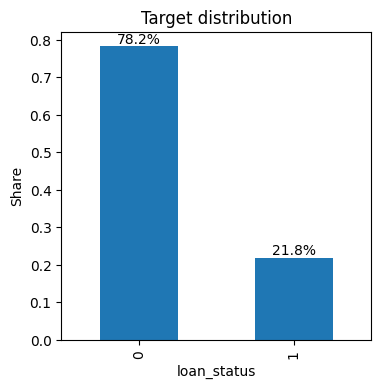

In [6]:
plt.figure(figsize=(4,4))
ax = df['loan_status'].value_counts(normalize=True).plot(kind='bar')
plt.title("Target distribution")
plt.ylabel("Share")

for p in ax.patches:
    ax.annotate(f"{p.get_height():.1%}",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom')

plt.show()


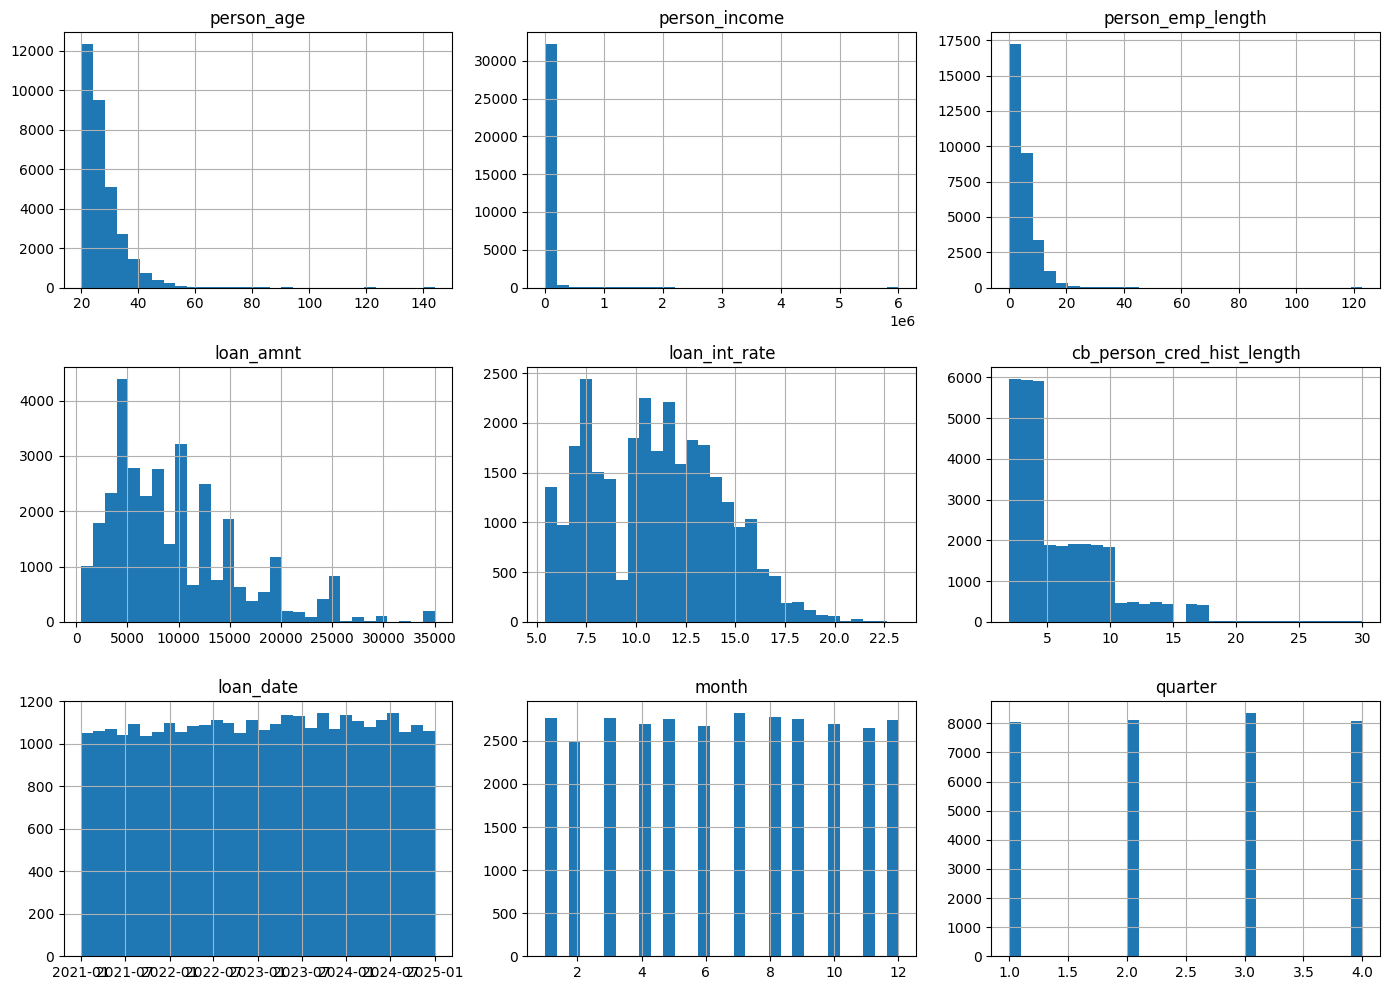

In [7]:
num_cols = df.select_dtypes(exclude='object').columns.drop('loan_status')

df[num_cols].hist(figsize=(14,10), bins=30)
plt.tight_layout()
plt.show()


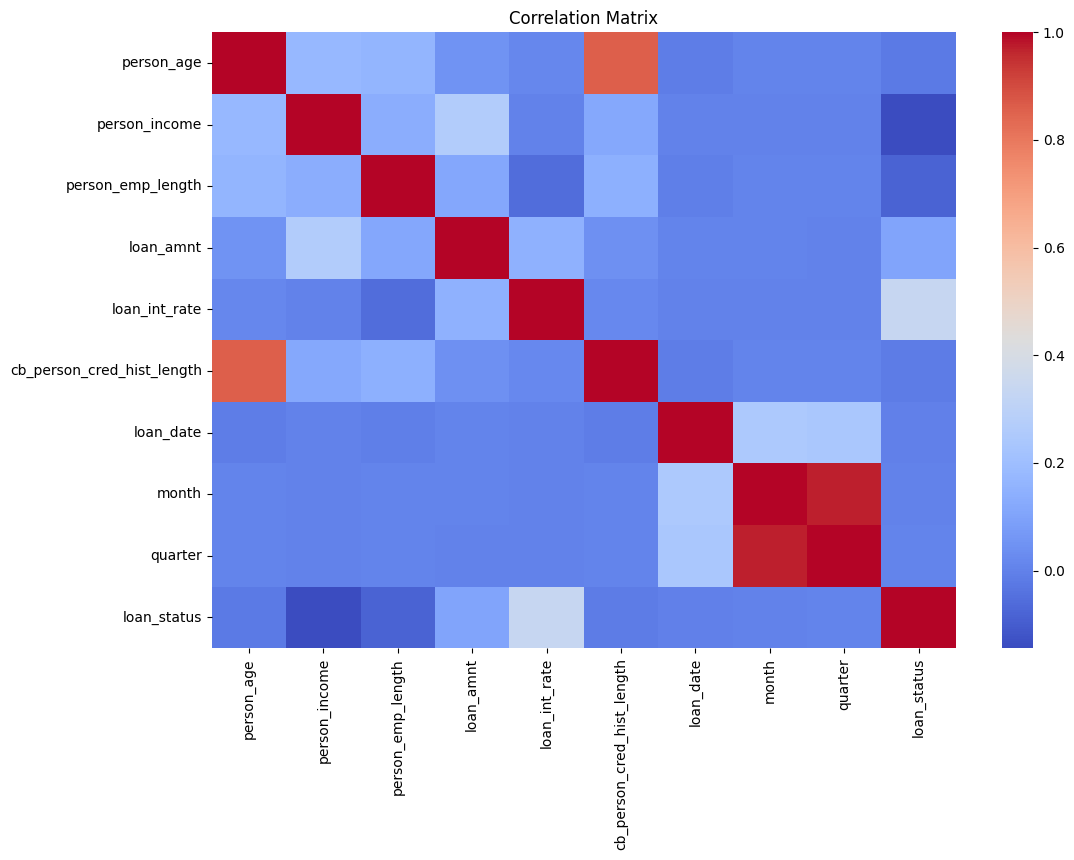

In [8]:
plt.figure(figsize=(12,8))
corr = df[num_cols.tolist() + ['loan_status']].corr()

sns.heatmap(
    corr,
    cmap='coolwarm',
    annot=False
)
plt.title("Correlation Matrix")
plt.show()


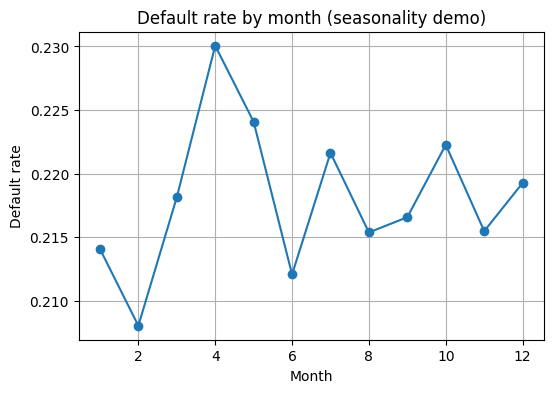

In [9]:
plt.figure(figsize=(6,4))
df.groupby("month")["loan_status"].mean().plot(marker="o")
plt.title("Default rate by month (seasonality demo)")
plt.ylabel("Default rate")
plt.xlabel("Month")
plt.grid()
plt.show()


In [10]:
df['person_emp_length'].fillna(df['person_emp_length'].median(), inplace=True)
df['loan_int_rate'].fillna(df['loan_int_rate'].median(), inplace=True)

C:\Users\sohibnazar.a\AppData\Local\Temp\ipykernel_2744\3887903077.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['person_emp_length'].fillna(df['person_emp_length'].median(), inplace=True)
C:\Users\sohibnazar.a\AppData\Local\Temp\ipykernel_2744\3887903077.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting

In [11]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import joblib

reco_features = [
    "person_age",
    "person_income",
    "person_emp_length",
    "loan_amnt",
    "loan_int_rate",
    "cb_person_cred_hist_length"
]

X_reco = df[reco_features]

scaler_reco = StandardScaler()
X_reco_scaled = scaler_reco.fit_transform(X_reco)

knn = NearestNeighbors(
    n_neighbors=10,
    metric="euclidean"
)
knn.fit(X_reco_scaled)

joblib.dump(knn, "../app/knn_recommender.pkl")
joblib.dump(scaler_reco, "../app/knn_scaler.pkl")

print("KNN recommender saved")


KNN recommender saved


In [12]:
X = df.drop(['loan_status','loan_date'], axis=1)
y = df['loan_status']

cat_cols = X.select_dtypes(include='object').columns
num_cols = X.select_dtypes(exclude='object').columns

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)


In [14]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)


In [15]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

log_reg = Pipeline(steps=[
    ('prep', preprocessor),
    ('model', LogisticRegression(max_iter=1000))
])

log_reg.fit(X_train, y_train) 

feature_names = (
    num_cols.tolist() +
    list(
        log_reg.named_steps["prep"]
        .named_transformers_["cat"]
        .get_feature_names_out(cat_cols)
    )
)

coefficients = log_reg.named_steps["model"].coef_[0]

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coef": coefficients
})



In [16]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)[:,1]

roc_auc = roc_auc_score(y_test, y_proba)
gini = 2 * roc_auc - 1

print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Gini: {gini:.4f}")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

ROC-AUC: 0.8374
Gini: 0.6748
[[7324  318]
 [1216  917]]
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      7642
           1       0.74      0.43      0.54      2133

    accuracy                           0.84      9775
   macro avg       0.80      0.69      0.72      9775
weighted avg       0.83      0.84      0.83      9775



In [17]:
def explain_prediction(log_reg, input_df, feature_names, top_n=5): 
    X_transformed = log_reg.named_steps["prep"].transform(input_df) 
    if hasattr(X_transformed, "toarray"):
        X_dense = X_transformed.toarray()
    else:
        X_dense = X_transformed

    contributions = X_dense[0] * log_reg.named_steps["model"].coef_[0]

    expl_df = pd.DataFrame({
        "feature": feature_names,
        "contribution": contributions
    })

    expl_df["abs_contribution"] = expl_df["contribution"].abs()
    expl_df = expl_df.sort_values("abs_contribution", ascending=False)

    return expl_df.head(top_n)


In [18]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

models = {
    "LogReg": log_reg,
    "RandomForest": Pipeline([
        ('prep', preprocessor),
        ('model', RandomForestClassifier(n_estimators=200, random_state=42))
    ]),
    "GradientBoosting": Pipeline([
        ('prep', preprocessor),
        ('model', GradientBoostingClassifier())
    ])
}

results = {}

for name, mdl in models.items():
    mdl.fit(X_train, y_train)
    proba = mdl.predict_proba(X_test)[:,1]
    results[name] = roc_auc_score(y_test, proba)

pd.DataFrame.from_dict(results, orient='index', columns=['ROC_AUC'])


,ROC_AUC
LogReg,0.837422
RandomForest,0.913832
GradientBoosting,0.913257


In [19]:
from sklearn.ensemble import VotingClassifier

ensemble = VotingClassifier(
    estimators=[
        ('lr', models['LogReg']),
        ('rf', models['RandomForest']),
        ('gb', models['GradientBoosting'])
    ],
    voting='soft'
)

ensemble.fit(X_train, y_train)

y_ens = ensemble.predict_proba(X_test)[:,1]
roc_auc_ens = roc_auc_score(y_test, y_ens)

print("Ensemble ROC-AUC:", roc_auc_ens)

Ensemble ROC-AUC: 0.9126554426379841


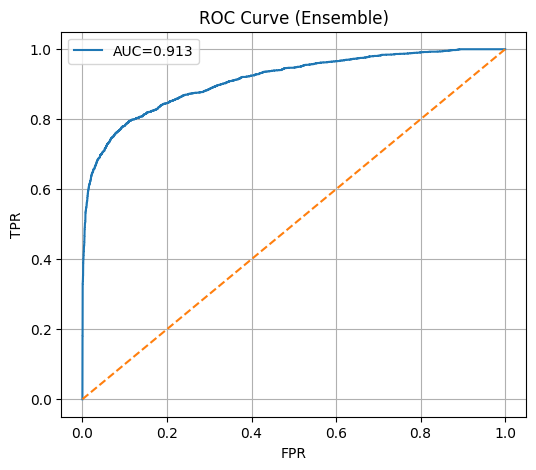

In [20]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_ens)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC={roc_auc_ens:.3f}")
plt.plot([0,1], [0,1], '--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve (Ensemble)")
plt.legend()
plt.grid()
plt.show()


In [21]:
example_client = X_test.iloc[[0]]

pd_value = log_reg.predict_proba(example_client)[0][1]

explanation = explain_prediction(
    log_reg,
    example_client,
    feature_names,
    top_n=5
)

print(f"PD: {pd_value:.2%}")
display(explanation)

PD: 46.70%


,feature,contribution,abs_contribution
4,loan_int_rate,1.271463,1.271463
18,cb_person_default_on_file_N,-0.539093,0.539093
8,person_home_ownership_MORTGAGE,-0.333629,0.333629
1,person_income,0.317739,0.317739
3,loan_amnt,0.273469,0.273469


In [22]:
import joblib
joblib.dump(log_reg, "../app/log_reg_explain.pkl")
joblib.dump(ensemble, "../app/credit_scoring_model.pkl")


['../app/credit_scoring_model.pkl']